Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

We want to maximize the fitness returned but minimize the number of calls.

First we will choose the genomes for reproduction (elitism, only pick the best)

Now we combine the genomes to create offsprings with crossovers (will have to tune the crossover rate)

We can also try to randomly flip some bits in the genomes (will have to tune mutation rate)

Evaluate the new offsprings only if it makes sense (i.e. if a genome was already evaluated we do not evaluate it)

And finally replace the worst performing with the new offsprings. Remember we want to minimze number of calls

In [326]:
from random import choices
from random import random
from random import randint
from random import sample
from random import seed
import lab9_lib
import numpy as np

In [327]:
seed(100)
np.random.seed(100)
fitness = None
def create_problem(x):
    global fitness
    if fitness is not None:
        fitness = None  # dont know if this is needed but whatever
    fitness = lab9_lib.make_problem(x)  # create the problem instance


In [328]:
# 1st method to call to create the population
def create_population(size=100, genome_length=1000):
    '''List (of size=size) of 0 and 1 each of lenght = genome_lenght'''
    return [choices([0, 1], k=genome_length) for _ in range(size)]

In [329]:
already_evaluated_genomes = {}  # needed to check if the genome was already evaluated

# used to evaluate the current population
def evaluate_population(population: list):
    '''Returns a dictionary with the individual fitness of each genome'''
    # might modify this to return a list instead
    pop_fitness = {}
    global calls_saved
    for individual in population:
        individual = tuple(individual)  # convert to a tuple to be used as a key
        if already_evaluated_genomes.get(individual) is not None:   # if the individual was already tested
            pop_fitness[individual] = already_evaluated_genomes.get(individual)
            # prints the genome in string form and the fitness of said genome
            # print(f"{''.join(str(g) for g in individual)}: {already_evaluated_genomes.get(individual):.2%}")
            calls_saved += 1
        else:
            # fitness(ind) calls the __call__ function and passes genome
            ind_fit = fitness(individual)
            pop_fitness[individual] = ind_fit
            already_evaluated_genomes[individual] = ind_fit
            # prints the genome in string form and the fitness of said genome
            # print(f"{''.join(str(g) for g in individual)}: {ind_fit:.2%}")
    return pop_fitness  # returns a dictionary

In [330]:
# select the genomes to mutate/crossover, already implements some randomnmessto pick worst results
def select_genomes(population: dict, size=10, pick_worse_prob = 0.15) -> dict:
    '''Receives as input a dictionary population, of which we only want to keep the most promising
    With a certain probability it can also pick random genomes instead.
    '''
    if len(population) > size:
        if random() < pick_worse_prob:  
            # literally just pick 4 random things
            # print("For this run, random genomes will be picked!")
            random_keys = sample(list(population.keys()), size)
            return {key : population[key] for key in random_keys}
        else: 
            # sort the dictionary based on the fitness, then pick the 4 most promising genomes
            # sorted returns a  list of tuples, so this one has to be kept under control because i am not sure lol
            # TODO CHECK HERE
            return dict(sorted(population.items(), key=lambda x: x[1], reverse=True)[:size])
    else:  
        # not worth selecting the best genomes yet
        return population

In [331]:
def tournament_selection(population: dict, tournament_size = 20):
    """Selects one individual from the population using tournament selection."""
    best_keys = []
    for _ in range(tournament_size):
        # randomly select genomes for the tournament
        tournament_genomes = sample(list(population.keys()), tournament_size)
        # Select the genome with the best fitness from the tournament
        best_keys.append(max(tournament_genomes, key=lambda genome: population[genome]))
    return {key : population[key] for key in best_keys}


In [332]:
def elitism(population: dict, elite_size=10):
    """Select the top individuals"""
    # ort the genomes based on fitness in descending order
    sorted_genomes = sorted(population, key=population.get, reverse=True)
    # select the top genomes
    elites = {genome: population[genome] for genome in sorted_genomes[:elite_size]}
    return elites

In [333]:
# method to call to print the population or to print the population + fitness after their evaluation
# ideally you will always call this after evaluatin the population btw
def print_population(population: list):
    if isinstance(population, dict):
        # handle dictionary logic
        for individual, fit in population.items():
            print(f"{''.join(str(g) for g in individual)}: {fit:.2%}")
    elif isinstance(population, list):
        for individual in population:
            print(f"{''.join(str(g) for g in individual)}")
    else:
        raise TypeError("Population must be a list or a dictionary")

In [334]:
def mutate(population: dict, mutation_rate=0.1) -> dict: 
    '''
    Each bit of each genome has a mutation_rate probability of switching
    returns a new dictionary after mutating the bits, see evaluate_population
    '''
    mutated_population = [] # population yet to be evaluated
    for individual, _ in population.items():
        # using numpy cause it's much faster
        np_individual = np.array(individual)
        # creating an array of random values between 0 and 1, we will switch basd on this mask
        random_values = np.random.rand(len(np_individual))
        mutation_mask = random_values < mutation_rate # mask of true and false
        np_individual[mutation_mask] = 1 - np_individual[mutation_mask]
        # back to tuples for evaluation
        mutated_individual = tuple(np_individual.tolist())
        mutated_population.append(mutated_individual)
        # switch the bits if it's less than mutation_rate
        # new_genome = (bit if random() > mutation_rate else 1 - bit for bit in individual)
        # mutated_population.append(new_genome)
    
    return evaluate_population(mutated_population)

In [335]:
def crossover(population: dict) -> dict:
    '''
    Create new offsprings by splitting two parents from a random bit.
    Notice that this method doubles the population so a new call to select_best_population might be good
    '''
    new_population = []
    old_population = list(population.keys())
    for i in range(0, len(old_population), 2):
        genitore1 = old_population[i]
        # next one in the population if possible otherwise the first element will be genitore2
        genitore2 = old_population[i+1] if i+1 < len(old_population) else old_population[0]
        # randint includes the extremes but in this case we do not want the, so we go from 1 to -1
        crossover_point = randint(1, len(genitore1)-1)
        # the end point is not included, starting point is included
        offspring1 = genitore1[:crossover_point] + genitore2[crossover_point:]
        offspring2 = genitore2[:crossover_point] + genitore1[crossover_point:]
        new_population.append(offspring1)
        new_population.append(offspring2)
    return evaluate_population(new_population)

In [336]:
def run_genetic_algo_static(
    x,
    population_size=100,
    genome_length=1000,
    mutation_rate=0.05,
    desired_fitness=50.00,
    num_max_generations=15000,
):
    best_genome = None
    best_fitness = float("-inf")
    generations = 0
    best_fitness_values = []

    create_problem(x)  # create the problem instance
    population = create_population(
        population_size, genome_length
    )  # create the population
    # print_population(population)

    while (best_fitness <= desired_fitness and generations < num_max_generations):  # until we reach a certain fitness
        fitnesses = evaluate_population(population)  # evaluate the current genomes
        # print_population(fitnesses)
        # best_genomes = select_genomes(fitnesses)  # select the best genomes (or randomly pick them)
        # print_population(best_genomes)
        
        # actually select only the best
        elites = elitism(fitnesses)
        #print(elites)
        # and the random ones
        parents = tournament_selection(fitnesses)
        # print(parents)
        crossed_genomes = crossover(parents)
        mutated_genomes = mutate(crossed_genomes, mutation_rate)
        new_population = elites.copy()
        new_population.update(mutated_genomes)
        
        # they say you want to crossover first and then mutate
        # crossed_genomes = crossover(best_genomes)
        # mutated_genomes = mutate(crossed_genomes, mutation_rate)
        # print_population(mutated_genomes)

        current_best_genome, current_best_fitness = max(new_population.items(), key=lambda x: x[1])
        # print(best_genome, best_fitness)

        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            best_genome = current_best_genome
            best_fitness_values.append(best_fitness)

        generations += 1

        if fitness.calls == 2000000:
            print("Oh shit")

    return best_genome, best_fitness, fitness.calls, generations, best_fitness_values

In [337]:
def run_genetic_algo_dynamic(
    x,
    population_size=50,
    genome_length=1000,
    mutation_rate=0.05,
    desired_fitness=50.00,
    max_stagnant_generations=100000,
    convergence_threshold=0.001,
):
    
    # function parameters
    best_genome = None
    best_fitness = float("-inf")
    last_best_fitness = float("-inf")
    generations = 0
    stagnant_generations = 0

    create_problem(x)  # create the problem instance
    population = create_population(population_size, genome_length)  # create the population
    # print_population(population)

    while best_fitness <= desired_fitness and stagnant_generations < max_stagnant_generations:  # until we reach a certain fitness
        fitnesses = evaluate_population(population)  # evaluate the current genomes
        # print_population(fitnesses)
        # print(fitnesses)
        # best_genomes = select_genomes(fitnesses)  # select the best genomes (or randomly pick them)
        # print_population(best_genomes)
        #print(best_genomes)

        # actually select only the best
        elites = elitism(fitnesses)
        #print(elites)
        # and the random ones
        parents = tournament_selection(fitnesses)
        # print(parents)
        crossed_genomes = crossover(parents)
        mutated_genomes = mutate(crossed_genomes, mutation_rate)
        new_population = elites.copy()
        new_population.update(mutated_genomes)
        
        # they say you want to crossover first and then mutate
        #crossed_genomes = crossover(best_genomes)
        #mutated_genomes = mutate(crossed_genomes, mutation_rate)
        # print_population(mutated_genomes)

        current_best_genome, current_best_fitness = max(new_population.items(), key=lambda x: x[1])
        # print(best_genome, best_fitness)
        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            best_genome = current_best_genome
            stagnant_generations = 0
        else:  # implement a check to see how many generations the fitness did not improve pr barely did
            fitness_improvement = best_fitness - last_best_fitness
            if fitness_improvement < convergence_threshold:
                stagnant_generations += 1
            else:
                stagnant_generations = 0

        last_best_fitness = best_fitness
        generations += 1

        # if fitness.calls % 200000 == 0:
        #    print(fitness.calls, best_fitness)

    return best_genome, best_fitness, fitness.calls, generations

In [338]:
mutation_rate = 0.01  # prob of each bit switching
calls_saved = 0  # just used to check if we save any calls
population_size = 100
desired_fitness = 0.9
x = [1, 2, 5, 10]
genome_length = 1000
num_max_generations = 20000
# if it is less than 1% improvement for max_stagn_generations
# lowering conver_threshold means that a lower improvement resets the generation counter
# higher value means it require larger improvement to reset the counter,
# so higher means more likely that the algorithms stops
max_stagnant_generations = 10000
convergence_threshold = 0.01   # 1% improvement for 10.000 generations

In [339]:
best_genome, best_fitness, num_calls, generations, best_fitness_values = run_genetic_algo_static(
    x=1,
    population_size=population_size,
    genome_length=genome_length,
    mutation_rate=mutation_rate,
    desired_fitness=desired_fitness,
    num_max_generations=num_max_generations
)

# best_genome, best_fitness, num_calls, generations = run_genetic_algo_dynamic(
#     x=1,
#     population_size=population_size,
#     genome_length=genome_length,
#     mutation_rate=mutation_rate,
#     desired_fitness=desired_fitness,
#     max_stagnant_generations=max_stagnant_generations,
#     convergence_threshold=convergence_threshold,
# )

In [340]:
print(f"The best fitness found is {best_fitness:.2f} with {num_calls} calls and {calls_saved} saved calls.")
print(f"It inspected {generations} generations and found {len(best_fitness_values)} improving solutions.")

The best fitness found is 0.58 with 277822 calls and 2114718 saved calls.
It inspected 20000 generations and found 10 improving solutions.


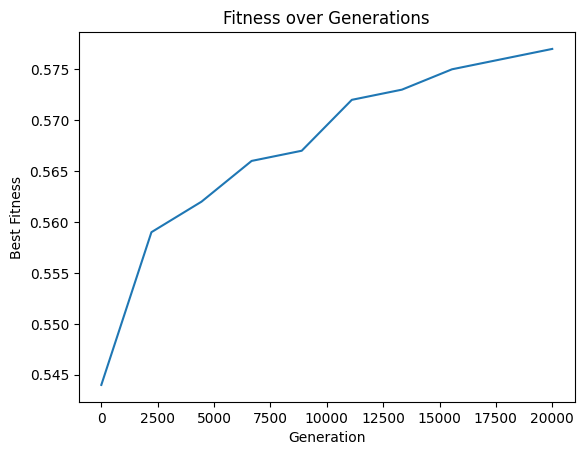

In [341]:
import matplotlib.pyplot as plt

plt.plot(np.linspace(0, generations, len(best_fitness_values)), best_fitness_values)
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Fitness over Generations')
plt.show()